<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/APTOS%202019%20Blindness%20Detection/APTOS_ResNet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aptos2019_blindness_detection_path = kagglehub.competition_download('aptos2019-blindness-detection')
crawford_resnet50_path = kagglehub.dataset_download('crawford/resnet50')

print('Data source import complete.')


<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Detect diabetic retinopathy to stop blindness before it's too late</center></h2>
<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png"></center>

In this synchronous Kernels-only competition, you'll build a machine learning model to speed up disease detection. You’ll work with thousands of images collected in rural areas to help identify diabetic retinopathy automatically. If successful, you will not only help to prevent lifelong blindness, but these models may be used to detect other sorts of diseases in the future, like glaucoma and macular degeneration.

In this notebook, I will be using basic deep learning and transfer learning (ResNet50) to create a baseline.
##### Image source: http://cceyemd.com/diabetes-and-eye-exams/

### Dependencies

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, applications # applications 來自 tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

2025-05-14 13:33:42.459097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747229622.701492      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747229622.772137      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load data

In [ ]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# EDA

## Data overview

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

## Label class distribution

As we can see we have an unbalanced database, we have two times more class 0 than 2, and classes 1, 2 and 4 each have less than half of the class 2 data.

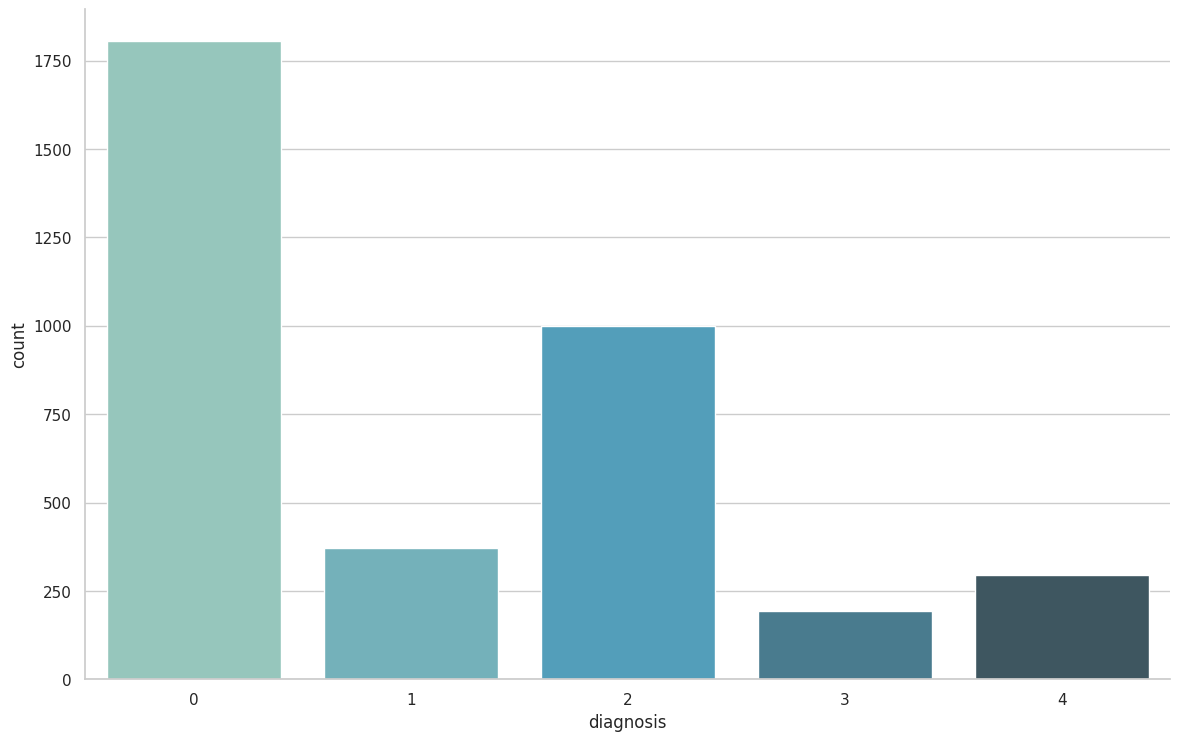

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

##### Legend
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR

### Now let's see some of the images

The images have different sizes, they may need resizing or some padding.

In [ ]:
print(train['id_code'].head())


0    000c1434d8d7
1    001639a390f0
2    0024cdab0c1e
3    002c21358ce6
4    005b95c28852
Name: id_code, dtype: object


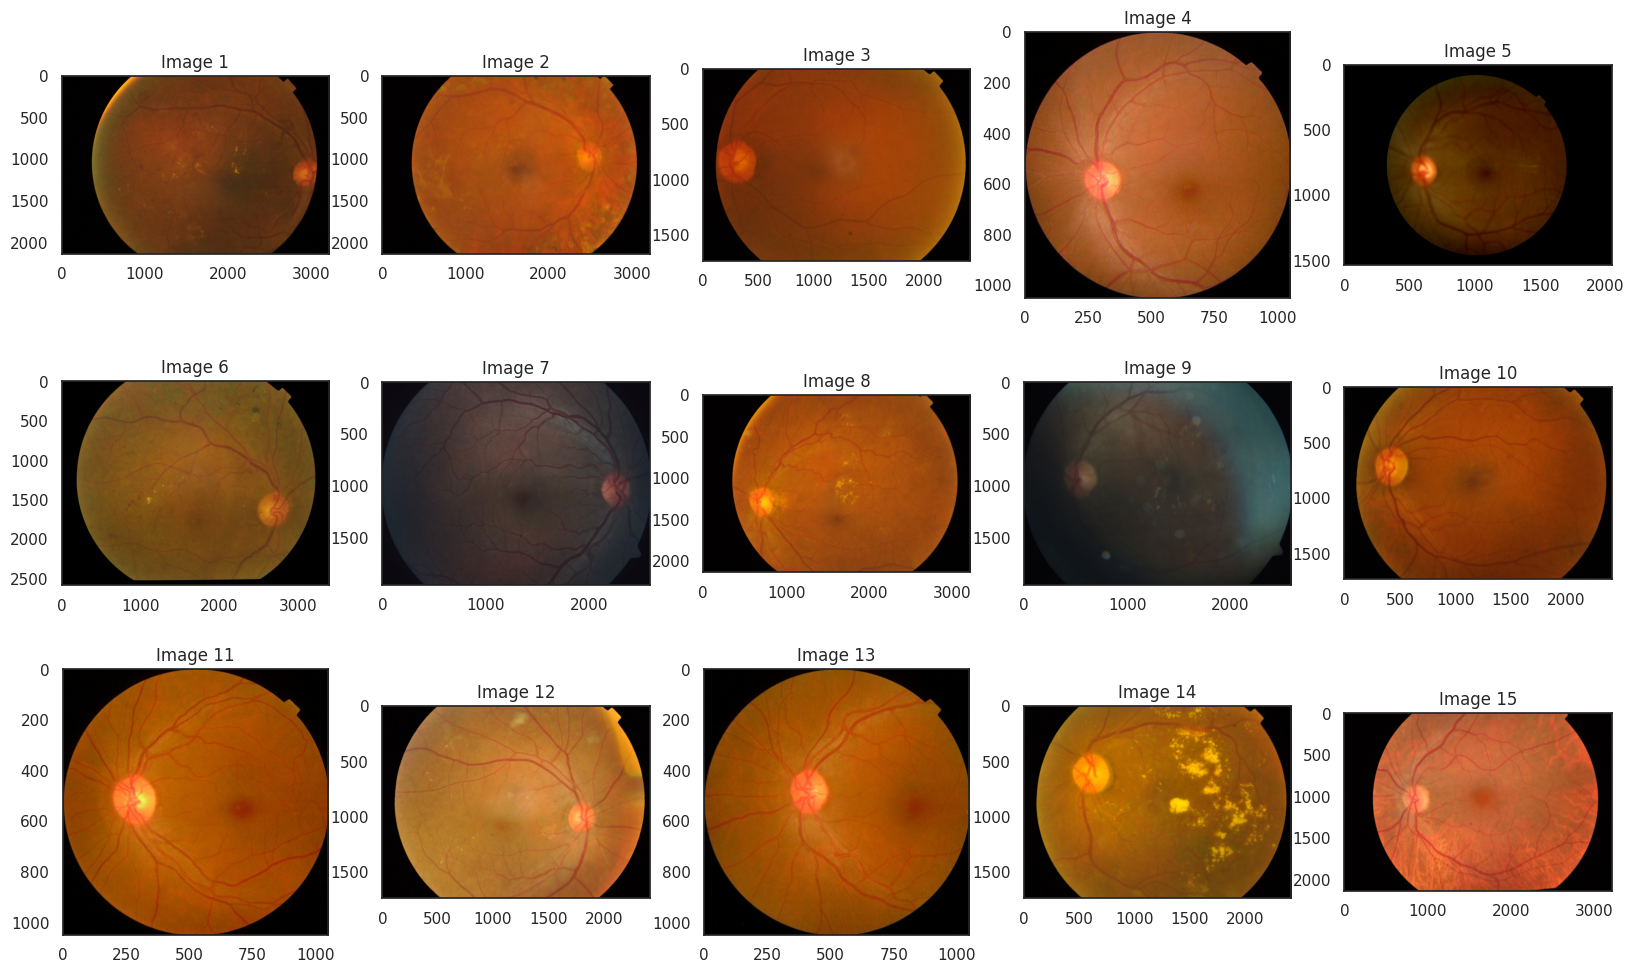

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img_path = f"../input/aptos2019-blindness-detection/train_images/{img_name}.png"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 🔺加上這一行才會是正常顏色
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

# Model parameters

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

id_code diagnosis
0  000c1434d8d7.png         2
1  001639a390f0.png         4
2  0024cdab0c1e.png         1
3  002c21358ce6.png         0
4  005b95c28852.png         0

## Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [ ]:

print(tf.__version__)
# 如果您獨立安裝了 Keras (較舊的用法)
# import keras
# print(keras.__version__)

2.18.0


In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
def create_resnet_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet',
                                       include_top=False,
                                       input_tensor=input_tensor)
   # base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(inputs=input_tensor, outputs=final_output)

    return model

In [ ]:
model = create_resnet_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

I0000 00:00:1747229655.559913      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 4,206,597 (16.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train top layers

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit(train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2


I0000 00:00:1747229673.742799      99 service.cc:148] XLA service 0x7abcbc002760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747229673.743893      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747229675.257817      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/366 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.2812 - loss: 3.3839   

I0000 00:00:1747229680.049220      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


366/366 ━━━━━━━━━━━━━━━━━━━━ 463s 1s/step - accuracy: 0.3608 - loss: 3.4683 - val_accuracy: 0.4588 - val_loss: 1.3535
Epoch 2/2
366/366 ━━━━━━━━━━━━━━━━━━━━ 76s 208ms/step - accuracy: 0.6250 - loss: 1.2511 - val_accuracy: 0.4615 - val_loss: 1.3407


# Fine-tune the complete model

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 27,741,189 (105.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history_finetunning = model.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.6649 - loss: 0.3264 - val_accuracy: 0.4615 - val_loss: 1.6871 - learning_rate: 1.0000e-04
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 78s 212ms/step - accuracy: 0.7500 - loss: 0.1481 - val_accuracy: 0.4588 - val_loss: 1.6741 - learning_rate: 1.0000e-04
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 362s 989ms/step - accuracy: 0.7977 - loss: 0.1898 - val_accuracy: 0.4657 - val_loss: 1.6868 - learning_rate: 1.0000e-04
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 77s 210ms/step - accuracy: 0.7500 - loss: 0.2391 - val_accuracy: 0.4657 - val_loss: 1.7515 - learning_rate: 1.0000e-04
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 366s 1000ms/step - accuracy: 0.8096 - loss: 0.1754 - val_accuracy: 0.7308 - val_loss: 0.3411 - learning_rate: 1.0000e-04
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 76s 208ms/step - accuracy: 0.7500 - loss: 0.1523 - val_accuracy: 0.7321 - val_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 358s 

# Model loss graph

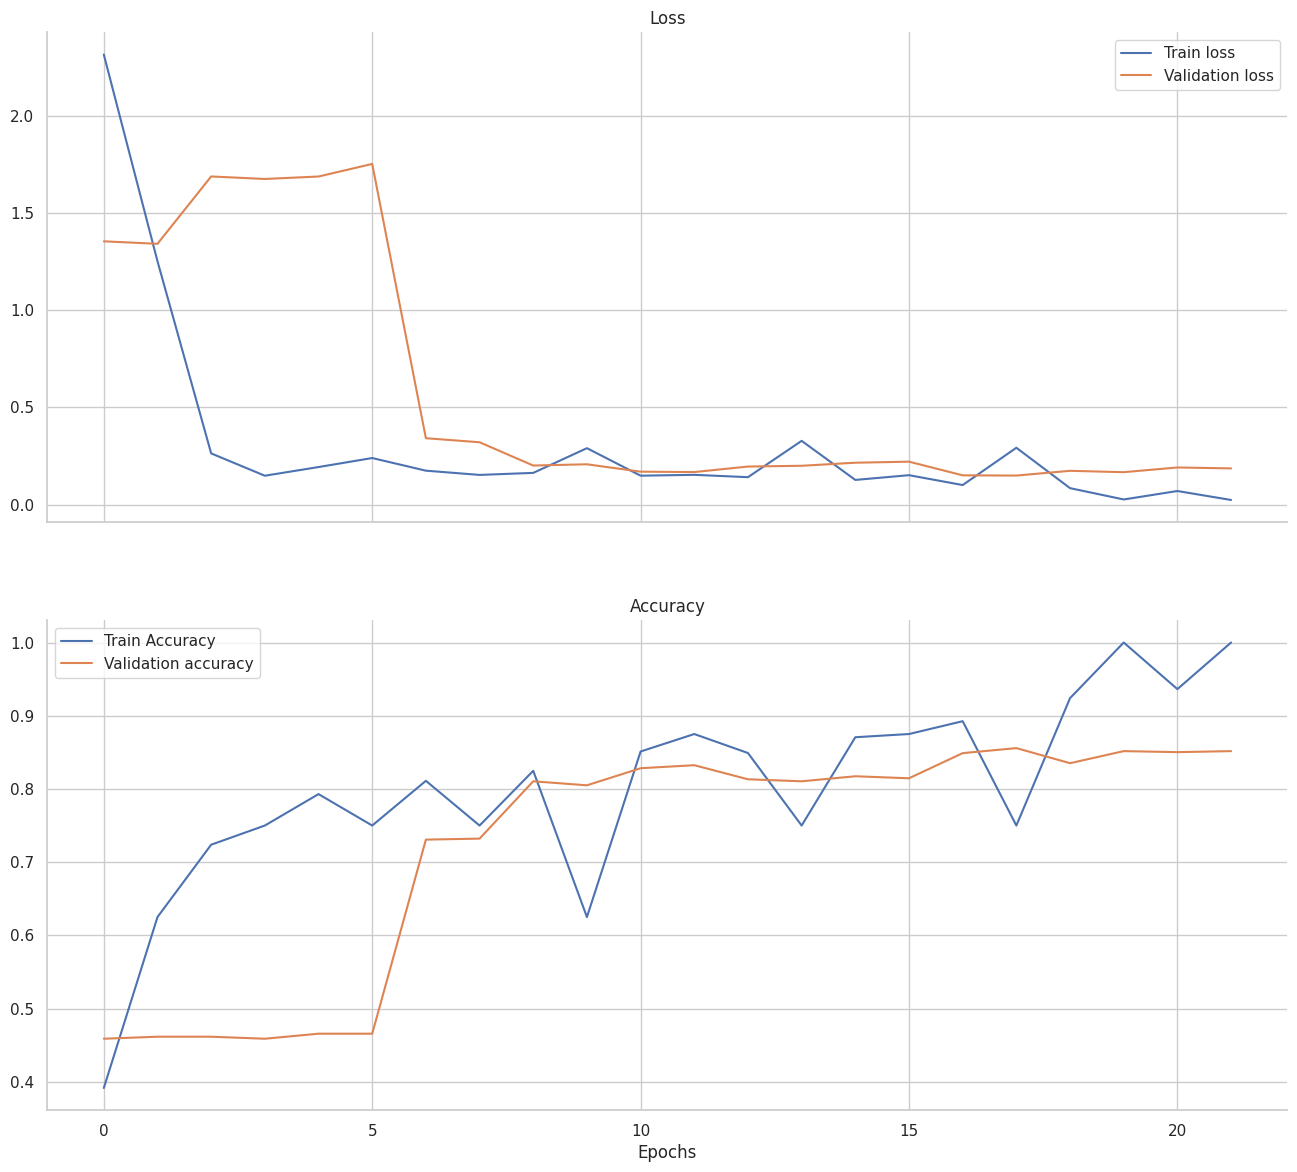

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'],
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'],
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(16, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.
3662/3662 ━━━━━━━━━━━━━━━━━━━━ 366s 99ms/step


## Confusion Matrix

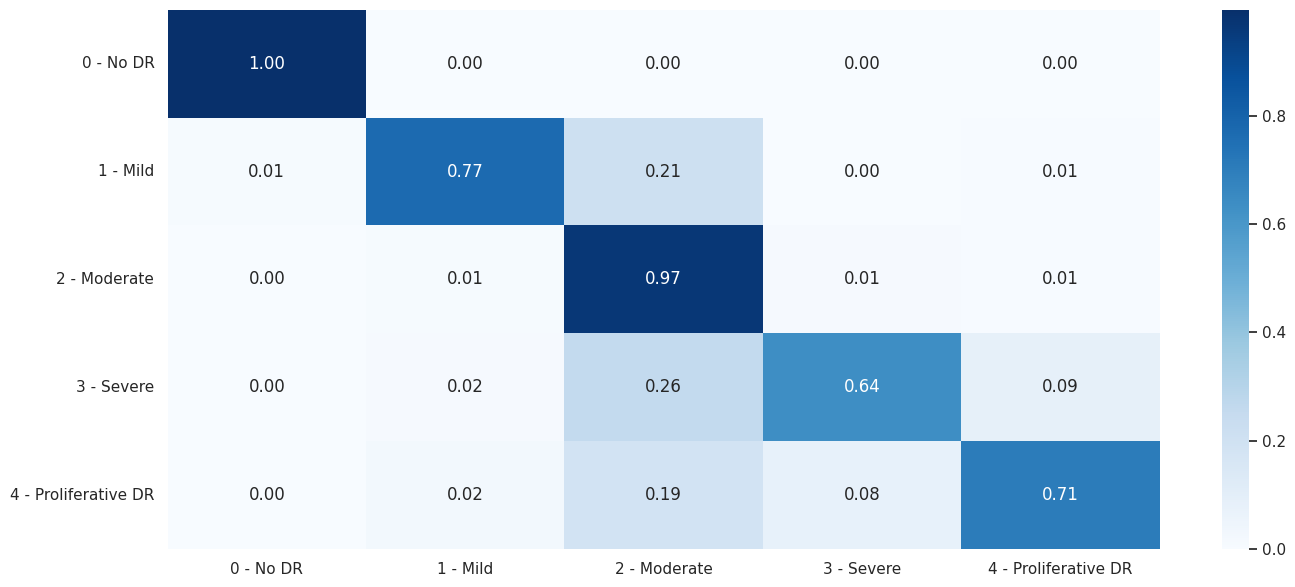

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [ ]:
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

## Quadratic Weighted Kappa

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.953


# Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

1928/1928 ━━━━━━━━━━━━━━━━━━━━ 87s 45ms/step


In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          2
5  009c019a7309          2
6  010d915e229a          3
7  0111b949947e          1
8  01499815e469          3
9  0167076e7089          0

## Predictions class distribution

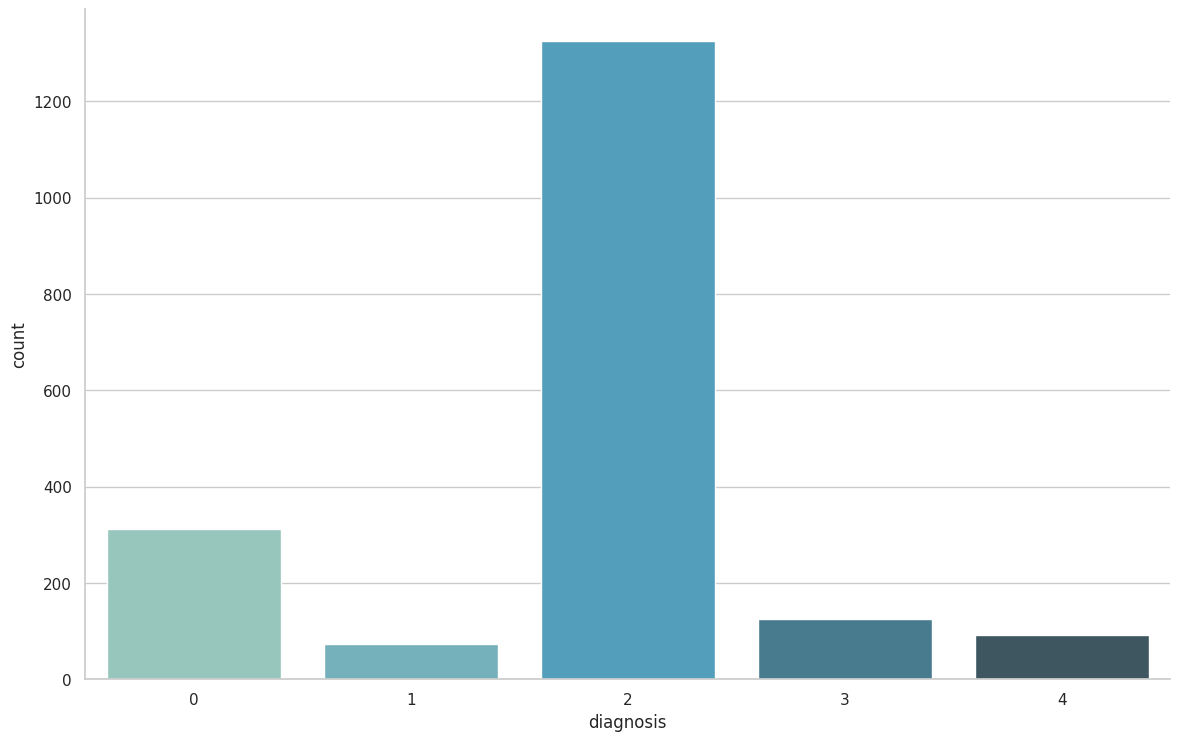

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

valid

In [ ]:
# 取得驗證集 Ground Truth
valid_generator.reset()
y_true = valid_generator.classes  # 真實標籤（0~4）

# 預測驗證集
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size + 1
y_probs = model.predict(valid_generator, steps=STEP_SIZE_VALID, verbose=1)
y_pred = np.argmax(y_probs, axis=1)


92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 888ms/step


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       361
           1       0.88      0.69      0.77        74
           2       0.81      0.99      0.89       200
           3       0.77      0.51      0.62        39
           4       0.91      0.71      0.80        59

    accuracy                           0.91       733
   macro avg       0.87      0.78      0.81       733
weighted avg       0.92      0.91      0.91       733



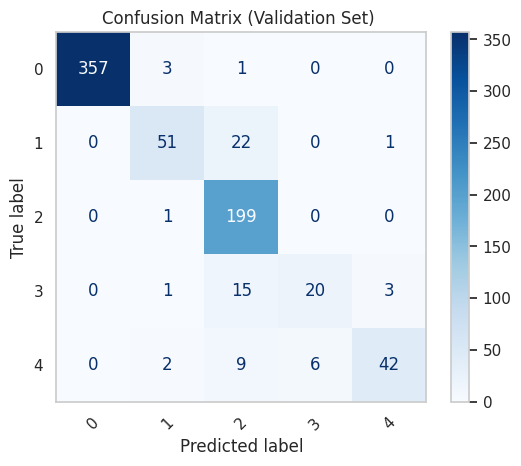

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("📊 Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set) ")
plt.grid(False)
plt.show()

In [ ]:
import random

# 從 valid_generator 中取出檔案名
valid_filenames = valid_generator.filenames
valid_df = pd.DataFrame({'filename': valid_filenames, 'true_label': y_true, 'pred_label': y_pred})

# 顯示 12 張圖片
plt.figure(figsize=(20, 10))
sample_indices = random.sample(range(len(valid_df)), 12)

for i, idx in enumerate(sample_indices):
    img_path = os.path.join(valid_generator.directory, valid_df['filename'].iloc[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512 ,512))

    true_label = valid_df['true_label'].iloc[idx]
    pred_label = valid_df['pred_label'].iloc[idx]

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length

Found 733 validated image filenames belonging to 5 classes.
733/733 ━━━━━━━━━━━━━━━━━━━━ 72s 98ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       361
           1       0.88      0.69      0.77        74
           2       0.81      0.99      0.89       200
           3       0.77      0.51      0.62        39
           4       0.91      0.71      0.80        59

    accuracy                           0.91       733
   macro avg       0.87      0.78      0.81       733
weighted avg       0.92      0.91      0.91       733



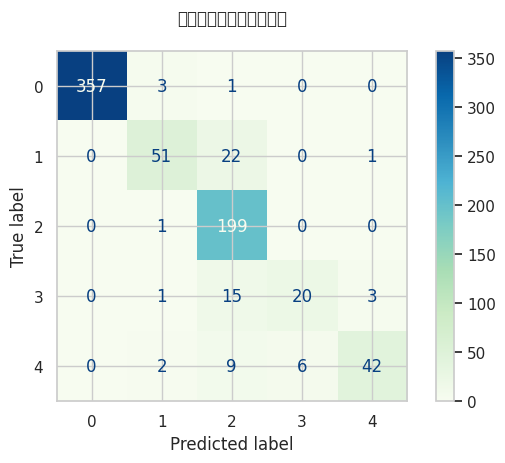

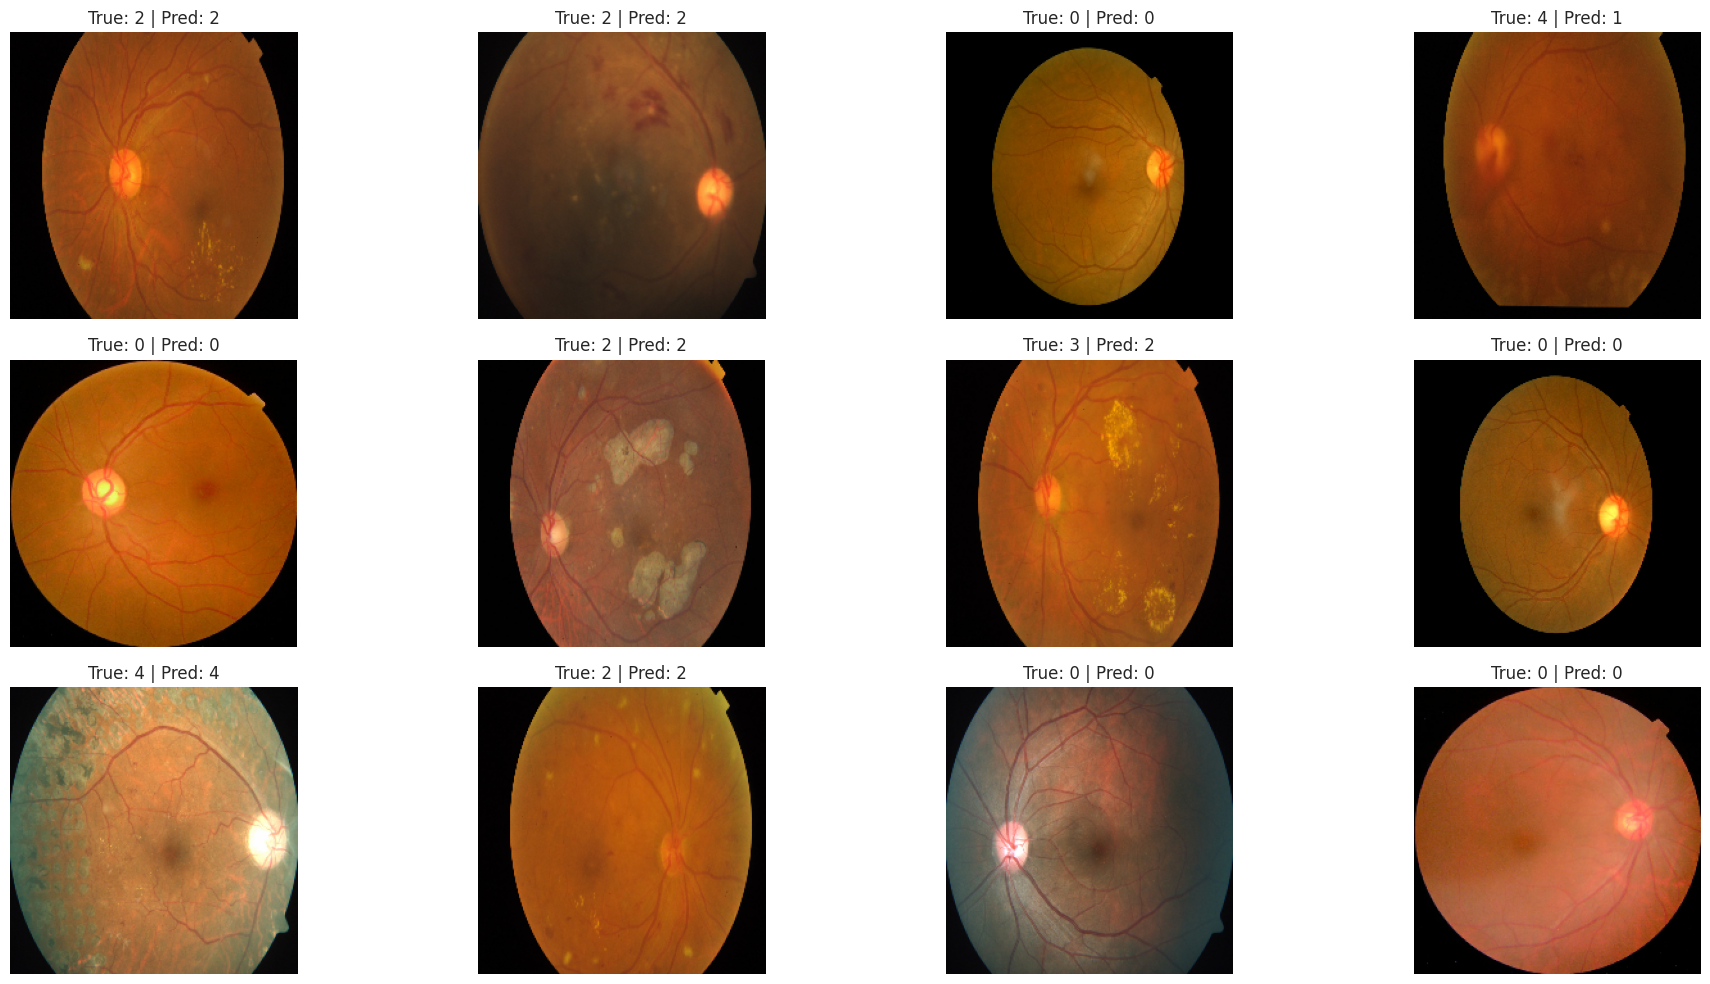

In [ ]:
# 6. 從 train.csv 分出一份作為本地測試集
from sklearn.model_selection import train_test_split

df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df['id_code'] = df['id_code'].apply(lambda x: x + ".png")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['diagnosis'])

# 7. 建立 test_generator
test_df['diagnosis'] = test_df['diagnosis'].astype(str)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    target_size=(512, 512),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

# 8. 模型預測
pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = pred_probs.argmax(axis=1)
y_true = test_generator.classes


733/733 ━━━━━━━━━━━━━━━━━━━━ 71s 97ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       361
           1       0.88      0.69      0.77        74
           2       0.81      0.99      0.89       200
           3       0.77      0.51      0.62        39
           4       0.91      0.71      0.80        59

    accuracy                           0.91       733
   macro avg       0.87      0.78      0.81       733
weighted avg       0.92      0.91      0.91       733



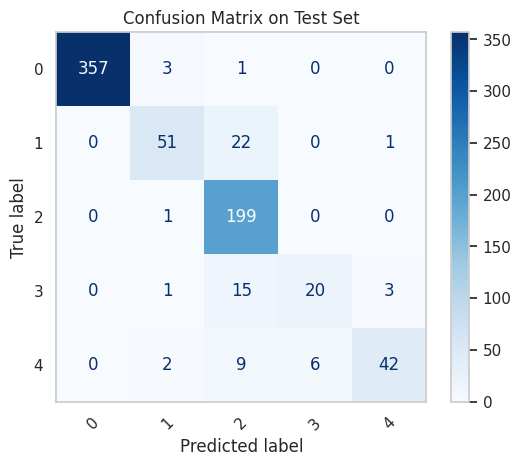

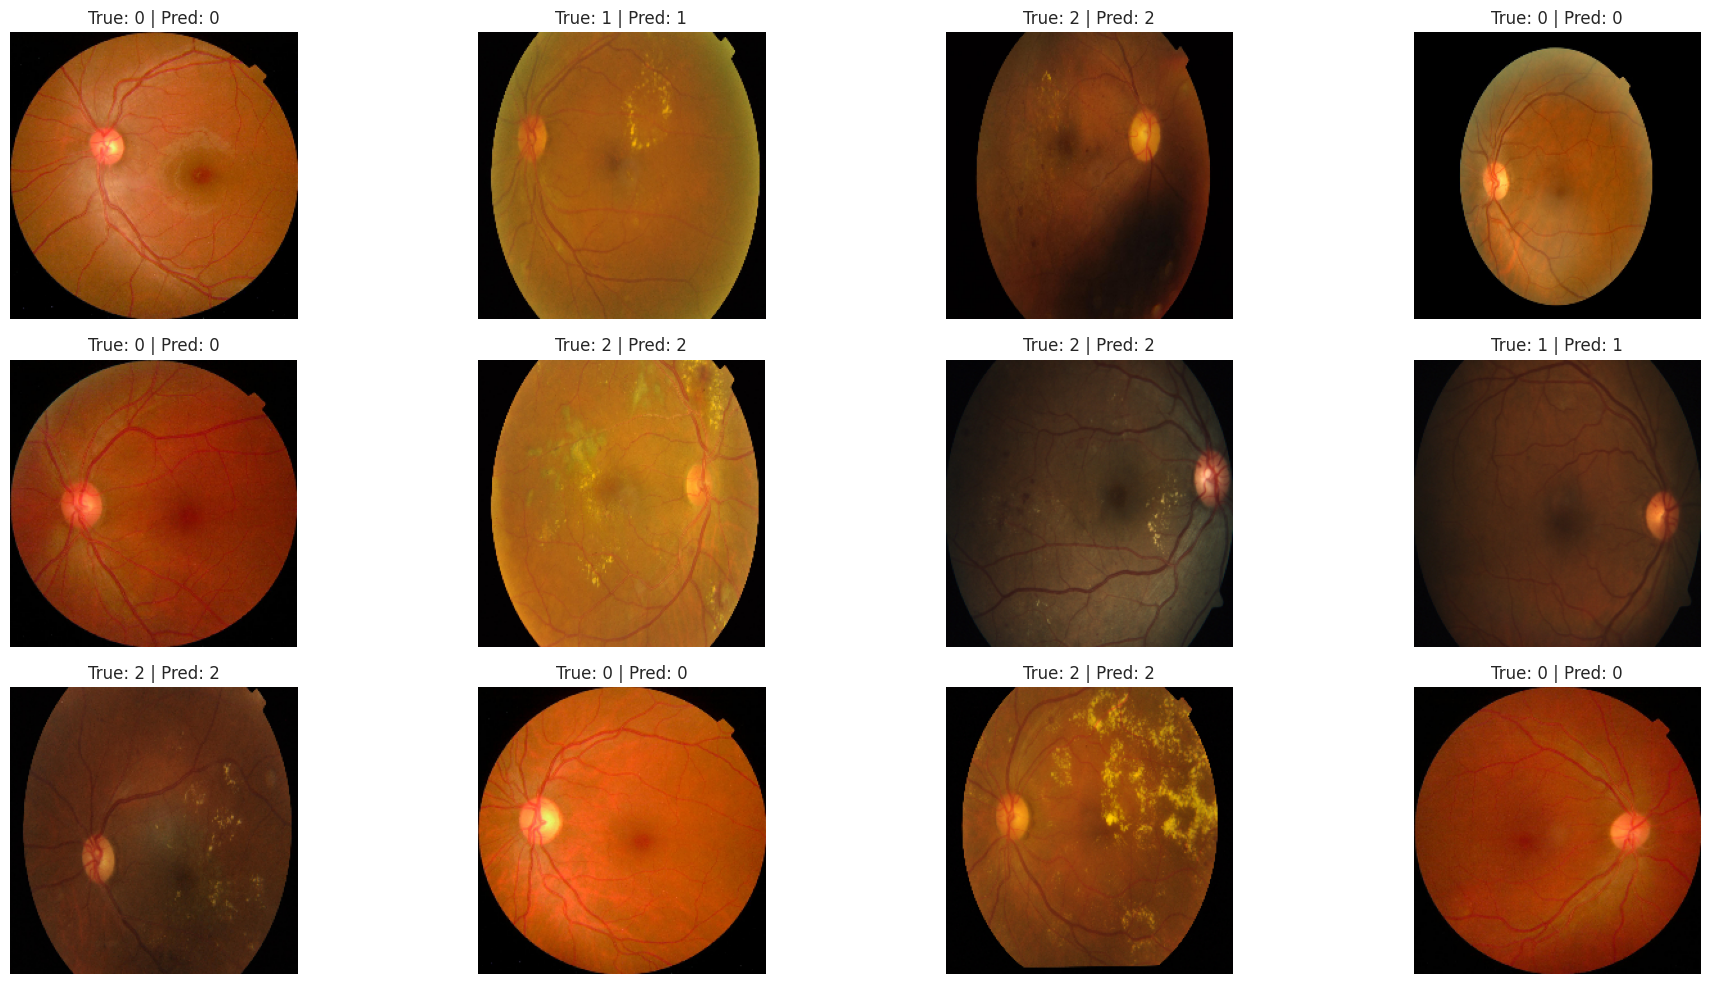

In [ ]:

# 9. 評估
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()
# 10. 可視化預測圖片
import cv2
import matplotlib.pyplot as plt
import random

filepaths = test_generator.filepaths
plt.figure(figsize=(20, 10))
for i in range(12):
    idx = random.randint(0, len(filepaths) - 1)
    img = cv2.imread(filepaths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
